In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN,GRU
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score,max_error,mean_squared_error,median_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Reading data from csv
data = pd.read_csv(r"C:\Users\RAGHAVENDRA\Desktop\FINAL_TF2_FILES\DATA\RSCCASN.csv",index_col='DATE',parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
data.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


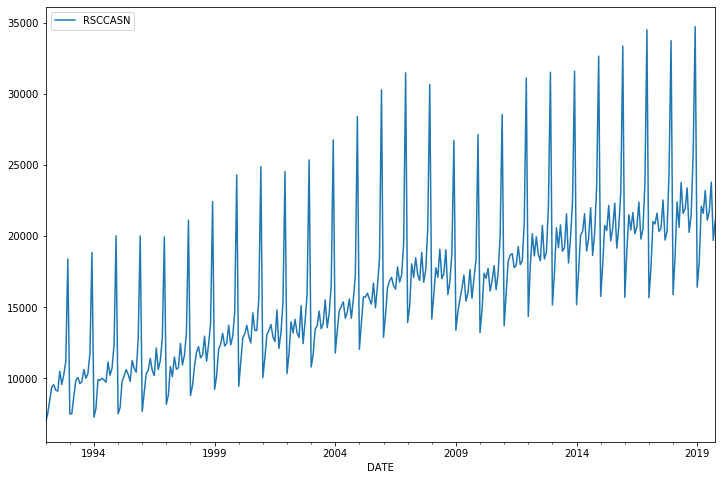

In [5]:
# Visualising data
data.plot(figsize=(12,8))
plt.show()

### Data Preprocessing

#### Splitting data

In [6]:
# I want 10% of the whole data has to be splitted to train and test
length = 0.1
split_length =len(data) -  int(len(data)*length)
train_data = data.iloc[:split_length]
test_data = data.iloc[split_length:]

len(train_data),len(test_data)

(301, 33)

#### Scaling data using MinMaxScaler

In [7]:
#scaling data
scaler = MinMaxScaler()
scale_train = scaler.fit_transform(train_data)
scale_test  = scaler.transform(test_data) 

#### Preparing Time series generator data for training as well as validation data

In [8]:
def timeserieGenerator(length=12,batch_size=1):
    train_generator = TimeseriesGenerator(scale_train,scale_train,length = length,batch_size = batch_size)
    
    validation_generator = TimeseriesGenerator(scale_test,scale_test,length = length,batch_size = batch_size)
    
    return train_generator,validation_generator,length

length = int(input("Enter the length:"))
batch_size = int(input("Enter Batch Size:"))

train_generator,validation_generator,length = timeserieGenerator(length,batch_size)


Enter the length:12
Enter Batch Size:1


### Building Model

In [9]:
def building_and_fitting_model(model_type,length=12,n_features = 1):
    
    
    model1 =  Sequential()
    model1.add(model_type(50,activation = 'relu',input_shape=(length,n_features)))
    model1.add(Dense(1))
    model1.compile(optimizer='adam',loss = 'mse')

    print(model1.summary())
    ES = EarlyStopping(monitor = 'val_loss',mode = 'min',patience=5)
    model1.fit_generator(train_generator,validation_data = validation_generator,epochs = 300,callbacks = [ES])
    
    print(str(model_type),":\n")
    df = pd.DataFrame(model1.history.history)
    df.plot()
    
    return model1

In [10]:

def forecast(to_be_forecasted,model):
    forecast = []
    first_eval_batch = scale_train[-length:]
    current_eval_batch = first_eval_batch.reshape((1,length,batch_size))
    
    for i in range(to_be_forecasted):
        
        prediction = model.predict(current_eval_batch)[0]
        forecast.append(prediction)
        current_eval_batch = np.append(current_eval_batch[:,1:,:],[[prediction]],axis=1)
        
    forecast = scaler.inverse_transform(forecast)
    
    return forecast
        
    
    
    

#### LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 21 steps
Epoch 1/300
289/289 [==============================] - 7s 23ms/step - loss: 0.0286 - val_loss: 0.0221
Epoch 2/300
289/289 [==============================] - 3s 11ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 3/300
289/289 [==============================] - 6s 21ms/step - loss: 0.0167 - val_loss: 0.0457
Epoch 4/300
289/289 [=============

C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


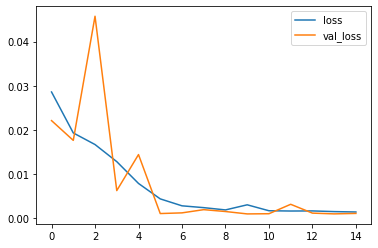

In [11]:
model_LSTM = building_and_fitting_model(LSTM,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_LSTM)
test_data["LSTM"] = forecast_points


### SimpleRNN


In [12]:
len(scale_test)

33

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 21 steps
Epoch 1/300
289/289 [==============================] - 6s 20ms/step - loss: 0.0206 - val_loss: 0.0083
Epoch 2/300
289/289 [==============================] - 3s 12ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 3/300
289/289 [==============================] - 3s 10ms/step - loss: 9.8295e-04 - val_loss: 0.0016
Epoch 4/300
289/289 [==============================] - 3s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoc

C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


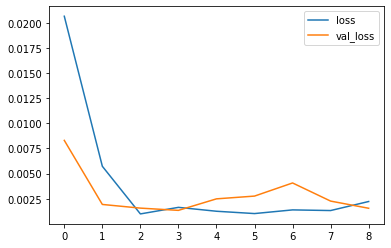

In [13]:
model_SRNN = building_and_fitting_model(SimpleRNN,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_SRNN)
test_data["SimpleRNN"] = forecast_points


### GRU

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________
None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 21 steps
Epoch 1/300
289/289 [==============================] - 8s 27ms/step - loss: 0.0307 - val_loss: 0.0251
Epoch 2/300
289/289 [==============================] - 4s 13ms/step - loss: 0.0209 - val_loss: 0.0205- ETA:
Epoch 3/300
289/289 [==============================] - 7s 25ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 4/300
289/289 [==============================] - 7s 24ms/step - loss: 0.0186 - val_loss: 0.0165
Ep

C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


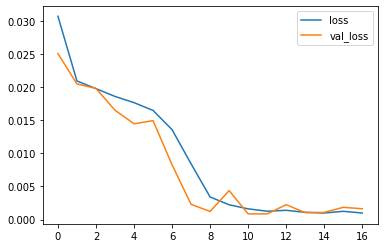

In [14]:
model_GRU = building_and_fitting_model(GRU,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_GRU)
test_data["GRU"] = forecast_points


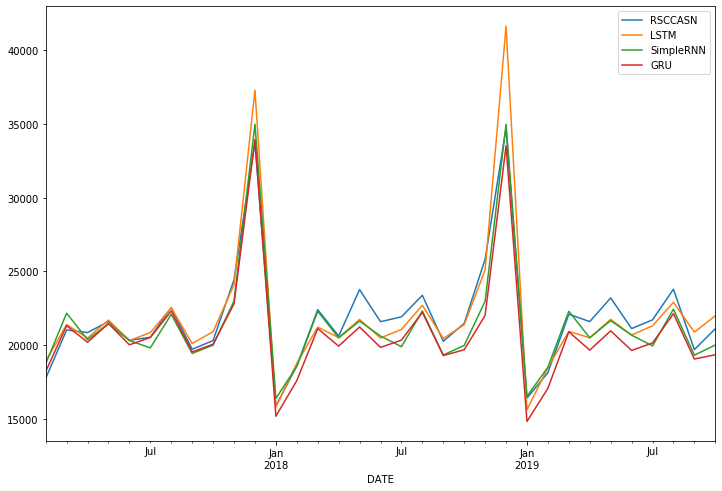

In [16]:
test_data.plot(figsize=(12,8))

### Evaluating model using reccursion metrics

In [22]:
def max_error_value(true,predicted):
    return max_error(true,predicted)

def r2score(true,predicted):
    return r2_score(true,predicted)

def mean_squared_error_value(true,predicted):
    return mean_squared_error(true,predicted)

def mean_squared_error_value(true,predicted):
    return mean_squared_error(true,predicted)



def evaluating_models():
    #Printing Max Error
    print("Max Error from LSTM:",max_error_value(test_data[['RSCCASN']],test_data[['LSTM']]))
    print("Max Error from SimpleRNN:",max_error_value(test_data[['RSCCASN']],test_data[['SimpleRNN']]))
    print("Max Error from GRU:",max_error_value(test_data[['RSCCASN']],test_data[['GRU']]))
    print("\n\n")
    #Mean Squared Error
    print("Mean Squared Error from LSTM: ",mean_squared_error_value(test_data[['RSCCASN']],test_data[['LSTM']]))
    print("Mean Squared Error from SimpleRNN: ",mean_squared_error_value(test_data[['RSCCASN']],test_data[['SimpleRNN']]))
    print("Mean Squared Error from GRU: ",mean_squared_error_value(test_data[['RSCCASN']],test_data[['GRU']]))
    print("\n\n")
    #r2_score
    rscr = 0
    model = 'LSTM'
    
    #LSTM
    rscr = r2score(test_data[['RSCCASN']],test_data[['LSTM']])
    print("r2_score From LSTM:",rscr)
    
    #SimpleRNN
    temp = r2score(test_data[['RSCCASN']],test_data[['SimpleRNN']])
    print("r2_score From SimpleRNN:",temp)
    
    if temp>rscr:
        rscr = temp
        model = 'SimpleRNN'
        
    #GRU    
    temp = r2score(test_data[['RSCCASN']],test_data[['GRU']])
    print("r2_score From GRU:",temp)
    
    if temp>rscr:
        rscr = temp
        model = 'GRU'
        
    print('\n\nBest Model Among All Is: ',model ,"With r2_score: ",rscr)
    
evaluating_models()
        
    

Max Error from LSTM: 6932.228821754456
Max Error from SimpleRNN: 2853.161606788639
Max Error from GRU: 3813.265411853794



Mean Squared Error from LSTM:  2436821.037504457
Mean Squared Error from SimpleRNN:  1203552.3144490453
Mean Squared Error from GRU:  1981421.7655668282



r2_score From LSTM: 0.8290642740266767
r2_score From SimpleRNN: 0.9155743957184854
r2_score From GRU: 0.8610091743530878


Best Model Among All Is:  SimpleRNN With r2_score:  0.9155743957184854


##### Based on the above, we are using SimpleRNN for predicting or forecasting for an year's data

### Forecasting results with the trained model of SimpleRNN

##### Note: More and more you forecast,introducing of noise is too much into data.

In [20]:
scaled_data_for_forecasting = scaler.fit_transform(data)

In [24]:
train_data.tail()

,RSCCASN
DATE,
2016-09-01,19790
2016-10-01,20500
2016-11-01,23644
2016-12-01,34482
2017-01-01,15663


In [32]:
period = int(input('Enter the number of years to be forecasted:'))
period *= 12
forecasting_result = forecast(period,model_SRNN)

Enter the number of years to be forecasted:4


In [33]:
forecating_index = pd.date_range(start='2017-02-01',periods=period,freq='MS')
forecating_index

DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [37]:
forecast_dataframe = pd.DataFrame(data = forecasting_result,index = forecating_index,
                                 columns = ['Forecast'])

In [41]:
# Forecasted dataframe
forecast_dataframe

,Forecast
2017-02-01,18828.968646
2017-03-01,22292.003469
2017-04-01,20475.996008
2017-05-01,21567.563766
2017-06-01,20422.078585
2017-07-01,19916.061837
2017-08-01,22210.843898
2017-09-01,19536.695131
2017-10-01,20108.566724
2017-11-01,23122.694085


##### plotting in different plots

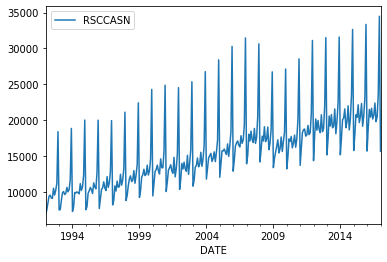

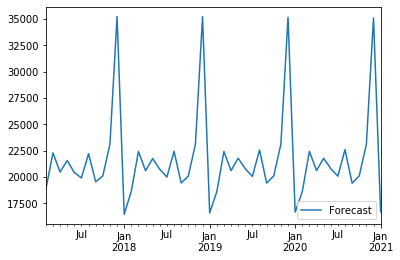

In [42]:
train_data.plot()
forecast_dataframe.plot()

##### Plotting in same axis

(540, 612)

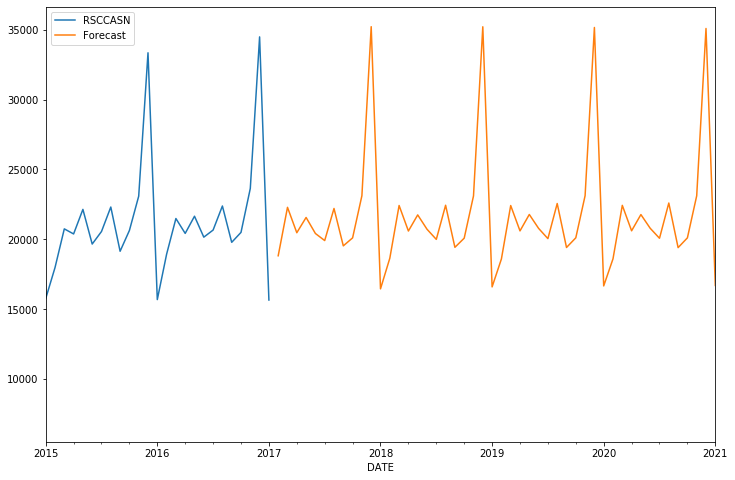

In [47]:
ax = train_data.plot(figsize=(12,8))
forecast_dataframe.plot(ax=ax)
plt.xlim('2015-01-01','2021-01-01')